In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import curve_fit as cv
import numpy as np
import pickle

# Labs 7 and 8

In [3]:
# open the file of interest, and use pickle loading
infile = open ("Sample_pt_250_500/qcd_100000_pt_250_500.pkl",'rb')
qcd_data = pickle.load(infile)
higgs_data = pickle.load(open ("Sample_pt_250_500/higgs_100000_pt_250_500.pkl",'rb'))

# list all keys of the files
print(qcd_data.keys())

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')


In [4]:

def histograms(var, name, units):
    plt.rcParams["figure.figsize"] = (40,50)  
    fig, ax = plt.subplots(2, 2)
    # Higgs data | log Higgs
    # ----------------------
    # QCD data  | log QCD
    higgs_hist = ax[0, 0]
    higgs_log = ax[0, 1]
    qcd_hist = ax[1, 0]
    qcd_log = ax[1, 1]


    a = higgs_hist.hist(higgs_data.get(var), density = True, bins = 50, alpha = 0.6)
    higgs_hist.set_title(name + ' for Higgs data set')
    higgs_hist.set_xlabel(name + units)
    higgs_hist.set_ylabel('frequency')

    b = higgs_log.hist(higgs_data.get(var), density = True, bins = 50, alpha = 0.8)
    higgs_log.set_title('Log of ' + name + ' for Higgs data set')
    higgs_log.set_yscale('log')
    higgs_log.set_xlabel(name + units)
    higgs_log.set_ylabel('log(frequency)')

    c = qcd_hist.hist(qcd_data.get(var), density = True, bins = 50, color = 'r', alpha = 0.6)
    qcd_hist.set_title(name + ' for QCD data set')
    qcd_hist.set_xlabel(name + units)
    qcd_hist.set_ylabel('frequency')

    d = qcd_log.hist(qcd_data.get(var), density = True, bins = 50, color = 'r', alpha = 0.8)
    qcd_log.set_title('Log of ' + name + ' for QCD data set')
    qcd_log.set_yscale('log')
    qcd_log.set_xlabel(name + units)
    qcd_log.set_ylabel('log(frequency)')
    
    for plot in [higgs_hist, higgs_log, qcd_hist, qcd_log]:
        plot.title.set_fontsize(48)
        for item in ([plot.xaxis.label, plot.yaxis.label] + plot.get_xticklabels() + plot.get_yticklabels()):
            item.set_fontsize(36)

To begin this lab, I will make a stacked histogram plot for the mass 

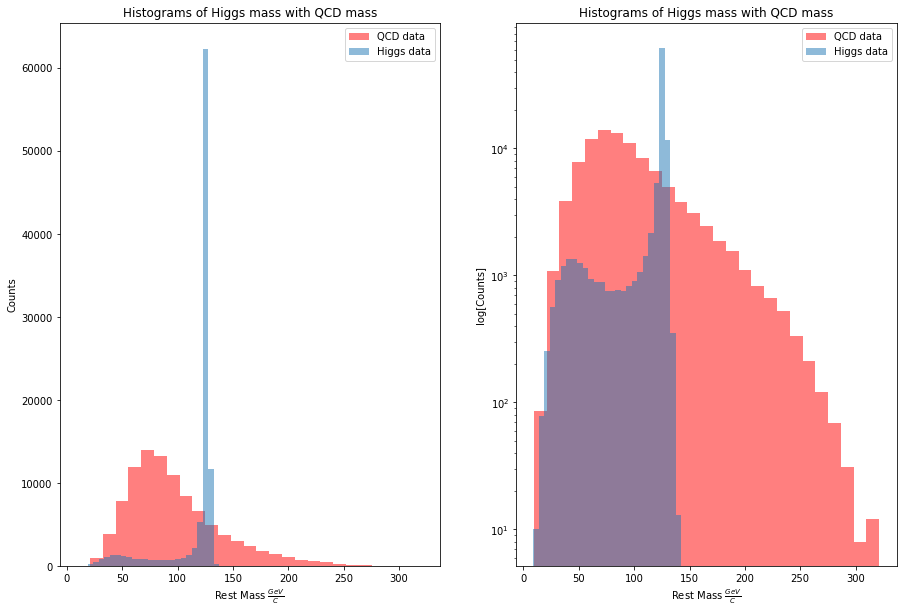

In [14]:
plt.rcParams["figure.figsize"] = (15,10)  
fig, ax = plt.subplots(1, 2)

ax[0].hist(qcd_data.get('mass'), color = 'red', alpha=0.5, label = 'QCD data', bins = 27)
ax[0].hist(higgs_data.get('mass'), alpha=0.5, label='Higgs data', bins = 27)
ax[1].hist(qcd_data.get('mass'), color = 'red', alpha=0.5, label = 'QCD data', bins = 27)
ax[1].hist(higgs_data.get('mass'), alpha=0.5, label='Higgs data', bins = 27)

ax[0].set_title('Histograms of Higgs mass with QCD mass')
ax[0].set_ylabel('Counts')
ax[0].set_xlabel(r'Rest Mass $\frac{GeV}{C}$')
ax[0].legend()

ax[1].set_title('Histograms of Higgs mass with QCD mass')
ax[1].set_ylabel('log[Counts]')
ax[1].set_xlabel(r'Rest Mass $\frac{GeV}{C}$')
ax[1].legend()
ax[1].set_yscale('log')

In [24]:
background_count = 20000 # given in dataset
total_count = background_count + 100 # given in dataset

prob = stats.poisson.sf(total_count, mu=background_count)

print('Significance: \t',prob)

special_ratio = (100) / (20000**0.5)

print('Ratio:         \t', special_ratio)

Significance: 	 0.23847212190687442
Ratio:         	 0.7071067811865475


The ratio of $\frac{N_{Higgs}}{\sqrt{N_{QCD}}}$ represents the ratio of the number of Higgs particles in our data set vs the standard deviation of the QCD background.  If this number is smaller than one, then the number of Higgs is inside of the standard deviation of the background, which is the case here.

For the QCD backgound, I only got a significance of 23.8%, which means that about a quarter of the time, I'd expect a number of events equal to the number I detected or higher.

To approach the problem of doing cuts to increase my significance, I must first weight the two distributions.

In [28]:
weight_higgs = higgs_data.get('mass').size / 100
weight_qcd = qcd_data.get('mass').size / 20000
print('Weight Higgs:\t',weight_higgs)
print('Weight QCD:\t',weight_qcd)

Weight Higgs:	 1000.0
Weight QCD:	 5.0


What this means is that 1000 Higgs counts in my data set corrospond to one Higgs detection and every 5 QCD counts in my data set corrospond to one QCD detection.  I can know cut the background to maximize my significance.

In [69]:
cut_level = 0
minimum_cut_level = 0
minimum_cut_sig = 1
significance = 1
five_sigma = stats.norm.sf(5)

while significance > five_sigma:
    cut_level += 0.1
    higgs_count = np.count_nonzero(higgs_data.get('mass') > cut_level) / weight_higgs
    qcd_count = np.count_nonzero(qcd_data.get('mass') > cut_level) / weight_qcd 
    significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)
    
    if significance < minimum_cut_sig and higgs_count > 0.0 and qcd_count > 0.0:
        minimum_cut_sig = significance
        minimum_cut_level = cut_level

        
max_cut_level = 0
max_cut_sig = 1
cut_level = int(qcd_data.get('mass').max())
significance = 1
while significance > five_sigma:
    cut_level -= 0.1
    higgs_count = np.count_nonzero((higgs_data.get('mass') > minimum_cut_level) & (higgs_data.get('mass') < cut_level)) / weight_higgs
    qcd_count = np.count_nonzero((qcd_data.get('mass') > minimum_cut_level) & (qcd_data.get('mass') < cut_level)) / weight_qcd
    significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)
    
    if significance < max_cut_sig and higgs_count > 0.0 and qcd_count > 0.0:
        max_cut_level = cut_level
        max_cut_sig = significance
  

higgs_count = np.count_nonzero((higgs_data.get('mass') > minimum_cut_level) & (higgs_data.get('mass') < max_cut_level)) / weight_higgs
qcd_count = np.count_nonzero((qcd_data.get('mass') > minimum_cut_level) & (qcd_data.get('mass') < max_cut_level)) / weight_qcd
significance = stats.poisson.sf(higgs_count + qcd_count, mu=qcd_count)
print('Min Cut Level:\t', np.round(minimum_cut_level, decimals=2))
print('Max Cut Level:\t', np.round(max_cut_level, decimals=2))
print('Significance:\t', significance)
print('Higgs Counts:\t',int(higgs_count))
print('QCD Counts:\t',int(qcd_count) )

Min Cut Level:	 119.3
Max Cut Level:	 129.0
Significance:	 0.009418115498960086
Higgs Counts:	 73
QCD Counts:	 975


Note, it is actually impossible to get a $5\sigma$ significance on the mass because you start cutting out too much signal